<a href="https://colab.research.google.com/github/hmelberg/health-analytics-using-python/blob/master/pure_functions_code_expander.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creating notation and functions to deal with medical codes
# Case study: Charlson comorbidity index

One key problem when dealing with medical codes, is how to describe a group of codes that make up a disease in a short and efficient manner. For instance, there are many dozens of codes that belong under the general category of liver disease. Listing all codes every time we want to select a group of patients with a given conditions, becomes very cumbersome. Instead, we will develop a notation where you can use stars, hyphens and colons to describe sets of medical codes, and functions that expand the shorthand codes to the full set of codes.

The Charlson comorbidity index is a good exampe of the usefulness of these notational shortcuts because it requires an overview of all the medical codes relevant for about 20 comorbidities. This would be very verbose without some kind of special notation.



## Briefly about Charlson and the overall approach

The [Charlson Comorbidity Index](https://en.wikipedia.org/wiki/Comorbidity#Charlson_index) is used to measure the frailty a patient. For instance, when comparing two differnt treatments, it is important to make sure that the patients not only have the same severity of the disease, but also that they have the same level of general health. The Charlson Comorbidity index measures this by assinging each patient a score based on the existence of codes for different comorbidities. Here is an example of the comorbidities, their weights, and the medical codes behind the comorbidities from [Lee et al. 2018](http://dx.doi.org/10.5051/jpis.2018.48.2.92):

![some text](https://www.jpis.org/ArticleImage/1150JPIS/jpis-48-92-i001-l.jpg)

There are several different indicies and one could argue - and people do, of course! - about which index to use and how well the index captures how frail a patient is. One of the reasons there are different versions, is that coding systems differ across time and countries. This means that the precise codes that goes into the calculation will differ. Moreover, the score is supposed to be related to the probability of dying, and this has led some to create new categories and weights that they believe better reflect the importance of each comorbodity for the probability that a patient will die.

Here is an overview of some of these various versions from an article by [Fernando et al. in 2019](https://https://www.sciencedirect.com/science/article/pii/S1047279719301036) (See also [Lagergren and Brusselaers](https://www.ncbi.nlm.nih.gov/pubmed/29582935) for another good overview).

![alt text](https://ars.els-cdn.com/content/image/1-s2.0-S1047279719301036-gr2.jpg)


While it is useful to know the background of the index and the different versions, these discussions are not the focus of this notebook. Instead, the aim is to use the task of calculating the index as a case study for how to develop notation to express groups of codes and, in the second step, use these groups to calculate indicies such as the Charlson Comorbidity Index.  

In short, to calculate the index we have to: 
  - Create a data structure the describe the different diseases and their  medical codes
  - Calculate how many of the diseases each patient has and create a weighted sum for each patient based on the diagnoses she has
  
These two simple steps present surprisingly many interesting problems - and we will start with the first: How to store a list of medical codes that describe a disease?

Note that this notebook focuses more on devloping functions using standard Python and less on typical data science tools like Pandas and so on. This illustrates the importance of knowing Python in general in order to build efficient tools for data science. Some might feel that this is not their cup of tea, in which case you can skip this notebook and use the notation we develop without knowing the details behind how it works. 


# Connecting diagnoses and codes using smart notation

One of the diagnoses that is neede to calculate the Charlson Comorbidity Index, is tumors. The hard way to describe all the codes that indicates a tumor diagnosis, would be to specify every single individual diganostic code that is relevant for tumors:


In [ ]:
# Some ICD-10 diagnostic codes relevant to tumors
tumor = ['C77.0',
 'C77.1',
 'C77.2',
 'C77.3',
 'C77.4',
 'C77.5',
 'C77.6',
 'C77.7',
 'C77.8',
 'C77.9',
 'C78.0',
 'C78.1',
 'C78.2',
 'C78.3',
 'C78.4',
 'C78.5',
 'C78.6',
 'C78.8',
 'C78.9',
 'C79.0',
 'C79.1',
 'C79.2',
 'C79.3',
 'C79.4',
 'C79.5',
 'C79.6',
 'C79.7',
 'C79.8',
 'C79.9',
 'C80.0',
 'C80.1',
 'C80.2',
 'C80.3',
 'C80.4',
 'C80.5',
 'C80.6',
 'C80.7',
 'C80.8',
 'C80.9']

This approach is both cumbersome and dangerous. It is cumbersome because you have to type a lot of codes - and remember that ulcers is only one of  about 20 comorbidities that goes into the Charlson index. More importantly, it is dangerous in the sense it becomes more difficult to discover mistakes when you have long lists of codes. What if you had forgotten to type C78.7? (Yes, it is left out!). You might have discovered this at some point, but it demonstrates the usefulness of inventing notation that makes the description of codes less verbose and less error prone.

# Notation

There are at least three types of symbols that can make it easier to express  code groups:
* Stars: C77* would include all codes that start with C77
* Hyphen: C77-C80 would be shorthand for C77, C78, C79 and C80
* Colon: C77.0:D80.9 would include all codes that are defined in a codebook to be between C77.0 and D80.9 (including these codes themselves).

If this notation is allowed, we could write the codes describing (solid, metastatic) tumors as:


In [ ]:
tumor = 'C77.0-C80.9'
 

Or, if we allow combinations of notational symbols, we could write:

In [ ]:
tumor = 'C77*-C80*'


This kind of notation could simplify things, and make it easier to quickly specify different groups of codes. However, to make use of it we need functions that expand the codes that are written using the notation to the full list of proper codes that the computer can use. 


These functions are not too difficult, but there are some tricky corners around leading zeros and the precision of decimals. For instance, in order to make hyphen notation work, we could use the following logic to create a function:
* Take the string, split it on the hyphen (if it exist), and extract the number component of the start and the end code
* Make a list of all the numbers between start and stop (This requires us to convert the start and end to integers and remember the number of decimals and leading zeros since we later have to reconvert it back to its original format)
* Convert the list of all the number back to string codes with the same format it had originally (the prefix, leading zeros, number of decimals/trailing zeros, star notation).

In code:


In [ ]:
# function to expand a string like 'K51.2-K53.8' to a list of codes 

# Need regex to extract the number component of the input string
import re

from functools import singledispatch
# The singledispach decorator enables us to have the same name, but use 
# different functions depending on the datatype of the first argument.
#
# In our case we want one function to deal with a single string input, and
# another to handle a list of strings. It could all be handled in a single 
# function using nested if, but singledispatch makes it less messy and more fun!


# Here is the main function, it is just the name and an error message if the 
# argument does not fit any of the inputs that wil be allowed

@singledispatch
def expand_hyphen(expr):
  """
  Expands codes expression(s) that have hyphens to list of all codes

  Args:
      code (str or list of str): String or list of strings to be expanded 
  
  Returns:
      List of strings
  
  Examples:
      expand_hyphen('C00*-C26*')
      expand_hyphen('b01.1*-b09.9*')
      expand_hyphen('n02.2-n02.7')
      expand_hyphen('c00*-c260')
      expand_hyphen('b01-b09')
      expand_hyphen('b001.1*-b009.9*')
      expand_hyphen(['b001.1*-b009.9*', 'c11-c15'])
  Note:
      Unequal number of decimals in start and end code is problematic.
      Example: C26.0-C27.11 will not work since the meaning is not obvious:
      Is the step size 0.01? In which case C27.1 will not be included, while 
      C27.10 will be (and traing zeros can be important in codes)
  """
  raise ValueError('The argument must be a string or a list')

# register the function to be used if the input is a string
@expand_hyphen.register(str)
def _(expr):
    # return immediately if nothing to expand
    if '-' not in expr:
      return [expr]

    lower, upper = expr.split('-')
    
    lower=lower.strip()

    # identify the numeric component of the code
    lower_str = re.search("\d*\.\d+|\d+", lower).group()
    upper_str = re.search("\d*\.\d+|\d+", upper).group()
    # note: what about european decimal notation?
    # also note: what if multiple groups K50.1J8.4-etc


    lower_num = int(lower_str.replace('.',''))
    upper_num = int(upper_str.replace('.','')) +1
    
    if upper_num<lower_num:
      raise ValueError('The start code cannot have a higher number than the end code')

    # remember length in case of leading zeros 
    length = len(lower_str)

    nums = range(lower_num, upper_num)

    # must use integers in a loop, not floats
    # which also means that we must multiply and divide to get decimal back
    # and take care of leading and trailing zeros that may disappear
    if '.' in lower_str:
      lower_decimals = len(lower_str.split('.')[1])
      upper_decimals = len(upper_str.split('.')[1])
      if lower_decimals==upper_decimals:
        multiplier = 10**lower_decimals
        codes = [lower.replace(lower_str, format(num /multiplier, f'.{lower_decimals}f').zfill(length)) for num in nums]
      # special case: allow k1.1-k1.123, but not k.1-k2.123 the last is ambigious: should it list k2.0 only 2.00?
      elif (lower_decimals<upper_decimals) & (upper_str.split('.')[0]==lower_str.split('.')[0]):
        from_decimal = int(lower_str.split('.')[1])
        to_decimal = int(upper_str.split('.')[1]) +1
        nums = range(from_decimal, to_decimal)
        decimal_str = '.'+lower.split('.')[1]
        codes = [lower.replace(decimal_str, '.'+str(num)) for num in nums]
      else:
        raise ValueError('The start code and the end code do not have the same number of decimals')
    else:
        codes = [lower.replace(lower_str, str(num).zfill(length)) for num in nums]
    return codes
 

# register the function to be used if if the input is a list of strings
@expand_hyphen.register(list)
def _(exprs):
  extended = []
  for expr in exprs:
    extended.extend(expand_hyphen(expr))
  return extended


And here are some examples:

In [7]:
# very standard expansion
expand_hyphen('K50-K54')

['K50', 'K51', 'K52', 'K53', 'K54']

In [8]:
# Leaving out the K in the end code also works
expand_hyphen('K50-54')

['K50', 'K51', 'K52', 'K53', 'K54']

In [9]:
# hyphen-expansion with stars keep the stars
expand_hyphen('K50*-K54*')

['K50*', 'K51*', 'K52*', 'K53*', 'K54*']

In [10]:
# expansion with decimals also work
expand_hyphen('K50.9-K51.2')

['K50.9', 'K51.0', 'K51.1', 'K51.2']

In [11]:
# expansion with decimals and stars 
# (but usually unnecessary to have decimals here)
expand_hyphen('K50.*-K53.*')

['K50.*', 'K51.*', 'K52.*', 'K53.*']

In [12]:
# decimals and star combined are OK
expand_hyphen('K50.8*-K51.2*')

['K50.8*', 'K50.9*', 'K51.0*', 'K51.1*', 'K51.2*']

In [13]:
# leading zeros 
expand_hyphen('K09.8-K10.2')

['K09.8', 'K09.9', 'K10.0', 'K10.1', 'K10.2']

In [14]:
# double digit with leading decimal zero
expand_hyphen('K1.99-K2.02')

['K1.99', 'K2.00', 'K2.01', 'K2.02']

In [15]:
# unequal number of main digits with unequal leading zeros
# note: Included K010.1, but not K10.1 
# (the pattern in the start code always has priority)
expand_hyphen('K009.8-K10.1')

['K009.8', 'K009.9', 'K010.0', 'K010.1']

In [16]:
# special case that works: unequal number of decimals, as long as main digits are the same
expand_hyphen('K01.8-K01.12')

['K01.8', 'K01.9', 'K01.10', 'K01.11', 'K01.12']

In [17]:
# different number of leading digits work as expected
expand_hyphen('K99.8*-K100.2*')

['K99.8*', 'K99.9*', 'K100.0*', 'K100.1*', 'K100.2*']

The behaviour so far is inuitive, but there are some corner cases that need to be discussed. For instance:
 
    expand_hyphen('K99.1-K100.11')
    expand_hyphen('K50.*-K51.2')
    expand_hyphen('K50.1-K51.15')
    expand_hyphen('K009.8-K10.1')

There are several issues here: Differences in the number of leading zeros, different length of the code, mixing notation, and different precision of decimals in the start and end codes. Because of this, there is no way to reliably fill in the intermediate codes in a non-ambigious manner. 

As an example, consider what codes should be generated if we write 'K50.1-K51.15'? Should the step size be 0.1 or 0.01? If it is 0.01, it would include  K50.20 but not K50.2. There is no inuitive solution and it would make a difference. Remember these are string codes where leading and trailing zeros could be significant for the result.



# dots and zeros

Many code systems are schizophrenic when it comes to dots and zeros. Sometimes they are included, sometimes they are not. For instance, the ICD-10 codes officially use decimals (K50.1), but are very often stored in the databases without decimals  (K501). Another example is the DRG codes which sometimes are used with leading zeros (002), but also presented as numbers without leading zeros (2).

It helps little to curse the world for being inconsistent, so the best we can do is to create functions that makes it easier to deal with it. Make it consistent by having a function that takes the dots away and delets the leading zeros (and optionally the trailing zeros too):

In [18]:
def del_dot(code):
  if isinstance(code, str):
    return code.replace('.','')
  else:
    codes = [c.replace('.','') for c in code]
  return codes

def del_zero(code, left=True, right=False):
  if isinstance(codes, str):
    codes=[code]
  if left:
    codes = [c.lstrip('0') for c in code]
  if right:
    codes = [c.rstrip('0') for c in code]
  if isinstance(code, str):
    codes=codes[0]
  return codes

# Star notation
Expanding codes using star notation is different from hyphens. Hyphens simply insert numbers in increasing order, but star notation requires an external codelist from which we can pick the codes conform with the given string. For instance, 'K50' should include all codes that start with *K50*, but we need the full set of codes to know which codes that start with *K50*. We can get this list in two ways:
* Find all unique codes from the codes that exist in the dataframe
* Use list of codes from an external codebook

Note that there are some small differences between the two approaches. Repeatedly constructing a list of codes from information in columns might be time consuming with large dataframes, and we should be careful to do it in the most efficient manner possible. Also, using the existing codes to define a list of codes, might not identify all possible codes. Instead it will only identify all those codes that have been used in the data. Expansion using 'all codes in my data' as opposed 'all codes in the official codebook' may produce different results. For many purposes we only want a list of those codes that actually exist in the data - and including irrelevant codes would just make things slower. But it is a difference one should be aware of.

As soon as we have a list of all possible codes, picking those that start with a given string, is very easy. The hard part is creating that list. 

We might, however, make the notation slightly more flexible. Instad of only allowing the user to search for everything that starts with a given pattern,  one might allow searching for all codes that end with a given string, for instance everything that ends with **B3*. Even more advanced, one could allow stars in the middle: Searching for codes that start with something and end with something. Finally, if more advanced searches are desired, we could allow expansion based on a regex pattern i.e. include those codes in a codelist that conform to a pattern described by a regex expression. Lastly, there might be codes that actually have stars and hyphens as part of the code itself - in which case we have to be careful not to expand the codes as if the hyphen or star were notational symbols (for instance by introducing a *raw=True* argument to indicate that the codes should not be expanded).

These complications will introduce themselves as we progress. For now, we need a function that creates a list of all possible codes by identifying the unique values in one or more columns:



In [19]:
# A function to identify all unique values in one or more columns 
# with one or multiple codes in each cell

import pandas as pd

def get_unique(df, cols=None, sep=None, all_str=False):
  # if no column(s) are specified, find unique values in whole dataframe
  if cols==None:
    cols=df.columns
  # multiple values with seperator in cells
  if sep:
    all_unique=set()

    for col in cols:
      new_unique = set(df[col].str.cat(sep=',').split(','))
      all_unique.update(new_unique)
  # single valued cells
  else:
    values = pd.unique(df[cols].values.ravel('K'))
  
  # if need to make sure all elements are strings without surrounding spaces
  if all_str:
    values=[str(value).strip() for value in values]

  return values

As long as we have a function to create the list of codes, expanding a code with star notation is a matter of iterating over the full codelist to find codes that start or end (or both) with the specified code string. Once again we create one function for a single code, and another function for when we want a list of codes to be expanded:

In [21]:
# A function to expand a string with star notation (K50*) 
# to list of all codes starting with K50

@singledispatch
def expand_star(code, codelist=None):
  """
  Expand expressions with star notation to a list of all values with the specified pattern
  
  Args:
    expr (str or list): Expression (or list of expressions) to be expanded
    codelist (list) : A list of all codes

  Examples:
    expand_star('K50*', codelist=icd9)
    expand_star('K*5', codelist=icd9)
    expand_star('*5', codelist=icd9)

  """
  raise ValueError('The argument must be a string or a list')

@expand_star.register(str)
def _(code, codelist=None): 
  # return immediately if there is nothing to expand
  if '*' not in code:
    return [code]
 
  start_str, end_str = code.split('*')

  if start_str and end_str:
    codes = {code for code in codelist if (code.startswith(start_str) & code.endswith(end_str))}

  if start_str:
    codes = {code for code in codelist if code.startswith(start_str)}
  
  if end_str:
    codes = {code for code in codelist if code.endswith(end_str)}

  return sorted(list(codes))

@expand_star.register(list)
def _(code, codelist=None):
  
  expanded=[]
  for star_code in code:
    new_codes = expand_star(star_code, codelist=codelist)
    expanded.extend(new_codes)
  
  # uniqify in case some overlap
  expanded = list(set(expanded))

  return sorted(expanded)



Before we test this, we might as well create the other funtions since they follow the same pattern. First, a function to expand a code using colons (from a given code, to a given code in a codelist, inclulding all codes in between). Second, a function to include only those codes in a codelist that follow a specified regex pattern. Lastly, we create a function that will handle everything i.e. do all the required expansions regardless of what type it is, and which also work when (relevant) notation is combined. Hyphen and star can be combined, regex and colon notation cannot be combined with anything else:

## Colon notation

Hyphen and star notation work fine if the codes are in the same main category (```tumor = 'C77*-C80*'```), but what if you want all codes from, say K40 to L52? In this case we cannot use hyphen or star, and the solution is colon notation. This notation includes all codes (as specified in a list) between two codes (that both must exist in the list). Here is the code:

In [22]:
# function to get all codes in a list between the specified start and end code 
# Example: Get all codes between K40:L52

@singledispatch
def expand_colon(code, codelist=None):
  raise ValueError('The argument must be a string or a list')

@expand_colon.register(str)
def _(code, codelist=None):
  """
  Expand expressions with colon notation to a list of complete code names
  code (str or list): Expression (or list of expressions) to be expanded
  codelist (list or array) : The list to slice from

  Examples
    K50:K52
    K50.5:K52.19
    A3.0:A9.3

  Note: This is different from hyphen and star notation because it can handle 
  different code lengths and different number of decimals 

  """
  if ':' not in code:
    return [code]
  
  startstr, endstr = code.split(':')
  
  # remove spaces
  startstr = startstr.strip()
  endstr =endstr.strip()

  # find start and end position
  startpos = codelist.index(startstr)
  endpos = codelist.index(endstr) + 1
  
  # slice list
  expanded = codelist[startpos:endpos+1]

  return expanded


@expand_colon.register(list)
def _(code, codelist=None, regex=False): 
  expanded=[]

  for cod in code:
    new_codes = expand_colon(cod, codelist=codelist)
    expanded.extend(new_codes)
  
  return expanded


## Expansion of codes based on regex

Notation using hyphen, star, and colon will often be enough to express codes efficiently, but sometimes it may also be useful to have the option of using more complex code expansion. For this purpose we could have a function that picks out all the codes from a codelist based on whether it fits the regex pattern you specify. This would allow almost all kinds of code expansions.

In [23]:

# Return all elements in a list that fits a regex pattern

@singledispatch
def expand_regex(code, codelist):
  raise ValueError('The argument must be a string or a list of strings')

@expand_regex.register(str)
def _(code, codelist=None):
  code_regex = re.compile(code)
  expanded = {code for code in codelist if code_regex.match(code)}
  # uniqify
  expanded = list(set(expanded))
  return expanded

@expand_regex.register(list)
def _(code, codelist):  
  expanded=[]

  for cod in code:
    new_codes = expand_regex(cod, codelist=codelist)
    expanded.extend(new_codes)
  
  # uniqify in case some overlap
  expanded = sorted(list(set(expanded)))

  return expanded

## A single function that does all the expansion (star, hyphen, colon, regex) and formatting (delete dots and zeros)

A list of codes may use a combination of several notations and instead of asking the user to apply all the different functions (hyphen, star, colon), we should have one function that expands and formats the codes regardless of the type of notation, but with an option of ignoring some symbols if you want (in case the star, colon or the hyphen is part of the actual code and not a notational symbol!):

In [24]:
@singledispatch
def expand_code(code, codelist=None, 
                hyphen=True, star=True, colon=True, regex=False, 
                drop_dot=False, drop_leading_zero=False,
                sort_unique=True):
  raise ValueError('The argument must be a string or a list of strings')

@expand_code.register(str)
def _(code, codelist=None, 
      hyphen=True, star=True, colon=True, regex=False, 
      drop_dot=False, drop_leading_zero=False,
      sort_unique=True):
  #validating input
  if (not regex) and (':' in code) and (('-' in code) or ('*' in code)):
    raise ValueError('Notation using colon must start from and end in specific codes, not codes using star or hyphen')

  if regex:
    codes = expand_regex(code, codelist=codelist)
    return codes
  
  if drop_dot:
    code = del_dot(code)
  
  codes=[code]

  if hyphen:
    codes=expand_hyphen(code)
  if star:
    codes=expand_star(codes, codelist=codelist)
  if colon:
    codes=expand_colon(codes, codelist=codelist)

  if sort_unique:
    codes = sorted(list(set(codes)))

  return codes

@expand_code.register(list)
def _(code, codelist=None, hyphen=True, star=True, colon=True, regex=False, 
      drop_dot=False, drop_leading_zero=False,
      sort_unique=True):
  
  expanded=[]

  for cod in code:
    new_codes = expand_code(cod, codelist=codelist, hyphen=hyphen, star=star, colon=colon, regex=regex, drop_dot=drop_dot, drop_leading_zero=drop_leading_zero)
    expanded.extend(new_codes)
  
  # uniqify in case some overlap
  expanded = list(set(expanded))

  return sorted(expanded)



## Get some data to test the functions and calculate Charlson index

To test the functions and to calculate the Charslon index we need some data. Here we will use data on hospital visits from Medicare: 


In [25]:
# Use pandas
import pandas as pd

In [26]:
# Read synthetic medicare sample data on inpatient hospital stays
path = 'https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/SynPUFs/Downloads/'
inpatient_file = 'DE1_0_2008_to_2010_Inpatient_Claims_Sample_1.zip'

inpatient = pd.read_csv(path+inpatient_file)

inpatient.columns = inpatient.columns.str.lower()
# easier to use a column called 'pid' than 'desynpuf_id'
inpatient['pid']=inpatient['desynpuf_id']

#set index to the personal id, but also keep id as a column
inpatient = inpatient.set_index('pid', drop=False)
inpatient.index.name='pid_index'


In [27]:
# Have a look
inpatient.head()

,desynpuf_id,clm_id,segment,clm_from_dt,clm_thru_dt,prvdr_num,clm_pmt_amt,nch_prmry_pyr_clm_pd_amt,at_physn_npi,op_physn_npi,...,hcpcs_cd_37,hcpcs_cd_38,hcpcs_cd_39,hcpcs_cd_40,hcpcs_cd_41,hcpcs_cd_42,hcpcs_cd_43,hcpcs_cd_44,hcpcs_cd_45,pid
pid_index,,,,,,,,,,,,,,,,,,,,,
00013D2EFD8E45D1,00013D2EFD8E45D1,196661176988405,1,20100312.0,20100313.0,2600GD,4000.0,0.0,3.139084e+09,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00013D2EFD8E45D1
00016F745862898F,00016F745862898F,196201177000368,1,20090412.0,20090418.0,3900MB,26000.0,0.0,6.476809e+09,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00016F745862898F
00016F745862898F,00016F745862898F,196661177015632,1,20090831.0,20090902.0,3900HM,5000.0,0.0,6.119985e+08,6.119985e+08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00016F745862898F
00016F745862898F,00016F745862898F,196091176981058,1,20090917.0,20090920.0,3913XU,5000.0,0.0,4.971603e+09,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00016F745862898F
00016F745862898F,00016F745862898F,196261176983265,1,20100626.0,20100701.0,3900MB,16000.0,0.0,6.408400e+09,1.960860e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00016F745862898F


In [28]:
# make a list of columns with information about diagnostic codes
icd_cols = list(inpatient.columns[inpatient.columns.str.startswith('icd9_dgns_cd')])
icd_cols

['icd9_dgns_cd_1',
 'icd9_dgns_cd_2',
 'icd9_dgns_cd_3',
 'icd9_dgns_cd_4',
 'icd9_dgns_cd_5',
 'icd9_dgns_cd_6',
 'icd9_dgns_cd_7',
 'icd9_dgns_cd_8',
 'icd9_dgns_cd_9',
 'icd9_dgns_cd_10']

Make a list of all unique ICD9 codes that exist, a codelist:

In [30]:
icd9 = get_unique(df=inpatient, cols = icd_cols, all_str=True)

## Try out some of the functions

In [31]:
pulmonary = expand_hyphen('490*-505*')
pulmonary 

['490*',
 '491*',
 '492*',
 '493*',
 '494*',
 '495*',
 '496*',
 '497*',
 '498*',
 '499*',
 '500*',
 '501*',
 '502*',
 '503*',
 '504*',
 '505*']

In [32]:
expand_star('404*', codelist=icd9)

['40400',
 '40401',
 '40402',
 '40403',
 '40411',
 '40412',
 '40490',
 '40491',
 '40492',
 '40493']

In [33]:
expand_star(pulmonary, codelist=icd9)

['490',
 '4910',
 '4911',
 '49120',
 '49121',
 '49122',
 '4918',
 '4919',
 '4920',
 '4928',
 '49300',
 '49301',
 '49302',
 '49310',
 '49312',
 '49320',
 '49321',
 '49322',
 '49382',
 '49390',
 '49391',
 '49392',
 '4940',
 '4941',
 '4950',
 '4957',
 '4959',
 '496',
 '500',
 '501',
 '502']

In [34]:
# Error, on purpose!
expand_colon('490:505', codelist=icd9) 

ValueError: '505' is not in list

In [35]:
expand_colon('490:502', codelist=sorted(icd9)) 

['490',
 '4910',
 '4911',
 '49120',
 '49121',
 '49122',
 '4918',
 '4919',
 '4920',
 '4928',
 '49300',
 '49301',
 '49302',
 '49310',
 '49312',
 '49320',
 '49321',
 '49322',
 '49382',
 '49390',
 '49391',
 '49392',
 '4940',
 '4941',
 '4950',
 '4957',
 '4959',
 '496',
 '500',
 '501',
 '502',
 '5060']

# Back to the future of Charlson calculations

Armed with notation it is still quite a task, but a much easier task, to describe the diagnoses and codes that make up the Charlsons Comorbidity Index:

In [36]:
# Codes to calculate CCI using ICD-9 (CM, US, Enhanced)
# Source: http://mchp-appserv.cpe.umanitoba.ca/concept/Charlson%20Comorbidities%20-%20Coding%20Algorithms%20for%20ICD-9-CM%20and%20ICD-10.pdf

infarction = '''
      410* 
      412*
      '''

heart_failure = '''
        390.91 
        402.21 402.11 402.91 
        404.01 404.03 404.11 404.13 404.91 404.93 
        425.4-425.9 
        428*
        '''

peripheral_vascular = '''
        093.0
        437.3
        440*
        441*
        443.1-443.9
        447.1
        557.1 557.9
        V43.4
        '''

cerebrovascular = '''
        362.34
        430*-438*
        '''
dementia = '''
        290*
        294.1
        331.2
        '''

pulmonary ='''
      416.8 416.9
      490*-505* 
      506.4
      508.1 508.8
      '''
rheumatic = '''
      446.5
      710.0-710.4
      714.0-714.2 714.8
      725*
      '''

peptic_ulcer = '531*-534*'

liver_mild ='''
      070.22
      070.23
      070.32
      070.33
      070.44
      070.54
      070.6
      070.9
      570.*
      571.*
      573.3 573.4 573.8 573.9
      V42.7
      '''
# Interesting, diabetes seems to be 5 digits long in the data, but not the specified codes
diabetes_without_complication = '250.0*-250.3* 250.8* 250.9*'

diabetes_with_complication = '250.4*-250.7*'

plegia = '''
    334.1
    342.*
    343.*
    344.0-344.6
    344.9
    '''

renal = '''
    403.01 403.11,403.91 
    404.02 404.03 404.12 404.13 404.92 404.93
    582.*  
    583.0-583.7
    585*
    586*
    588.0
    V42.0
    V45.1
    V56*
    '''

malignancy = '''
    140*-172*
    174.0-195.8
    200*-208*
    238.6
    '''

liver_not_mild = '''
    456.0-456.2
    572.2-572.8
    '''

tumor = '196*-199*'

hiv = '042*-044*'

Put all the strings that describe the codes for the comorbitities in a single datastructure:

In [37]:
# A dictionary with names of cormobitities and the associated medical codes

code_string = { 'infarction' : infarction, 
               'heart_failure' : heart_failure, 
               'peripheral_vascular' : peripheral_vascular, 
               'cerebrovascular' : cerebrovascular, 
               'dementia' : dementia, 
               'pulmonary' : pulmonary, 
               'rheumatic' : rheumatic, 
               'peptic_ulcer' : peptic_ulcer, 
               'liver_mild' : liver_mild, 
               'diabetes_without_complication' : diabetes_without_complication, 
               'diabetes_with_complication' : diabetes_with_complication, 
               'plegia' : plegia, 
               'renal' : renal, 
               'malignancy' : malignancy, 
               'liver_not_mild' : liver_not_mild, 
               'tumor' : tumor, 
               'hiv' : hiv}

Having created a codelist, we can use the functions we have created to expand the description for all the different comorbidities to include all the specific codes:

In [38]:
codes = {disease : expand_code(codes.split(), 
                               codelist=icd9,
                               drop_dot=True,
                               drop_leading_zero=True) 
        for disease, codes in code_string.items()}

And we can check if it really expanded the codes, for instance by examining the codes for mild liver disease:

In [39]:
codes['liver_mild']

['07022',
 '07023',
 '07032',
 '07033',
 '07044',
 '07054',
 '0706',
 '0709',
 '570',
 '5710',
 '5711',
 '5712',
 '5713',
 '57140',
 '57142',
 '57149',
 '5715',
 '5716',
 '5718',
 '5719',
 '5733',
 '5734',
 '5738',
 '5739',
 'V427']

In order to do the calculations, we need the weights associated with each comorbidity. These weights are related to the predictive power of the comorbididy for the probability of dying in a given time period. There are a few different standards, but with relatively minor variations. Here we use the following:


In [40]:
charlson_points = { 'infarction': 1, 
                   'heart_failure': 1, 
                   'peripheral_vascular': 1, 
                   'cerebrovascular': 1, 
                   'dementia': 1, 
                   'pulmonary': 1, 
                   'rheumatic': 1, 
                   'peptic_ulcer': 1, 
                   'liver_mild': 1, 
                   'diabetes_without_complication': 1, 
                   'diabetes_with_complication': 2, 
                   'plegia': 2, 
                   'renal': 2, 
                   'malignancy': 2, 
                   'liver_not_mild': 3, 
                   'tumor': 6, 
                   'hiv': 6}


We also need the function that takes a set of codes and identifies the rows and persons who have the codes (a function we developed in a previous notebook):

In [41]:
# mark rows that contain certain codes in one or more colums
def get_rows(df, codes, cols=None, sep=None, pid='pid'):
  """
  Make a boolean series that is true for all rows that contain the codes
  
  Args
    df (dataframe or series): The dataframe with codes
    codes (str, list, set, dict): codes to be counted
    cols (str or list): list of columns to search in
    sep (str): The symbol that seperates the codes if there are multiple codes in a cell
    pid (str): The name of the column with the personal identifier

  """
    
  # string as input for single codes is allowed
  # but then must make it a list
  if isinstance(codes, str):
    codes = [codes]
  
  # same for cols
  # must be a list sine we may loop over it
  if not isinstance(cols, list):
    cols = [cols]
  
  # approach depends on whether we have multi-value cells or not
  # if sep exist, then have multi-value cells
  if sep:
    # have multi-valued cells
    codes = [rf'\b{code}\b' for code in codes]
    codes_regex = '|'.join(codes)
    
    # starting point: no codes have been found
    # needed since otherwise the function might return None if no codes exist
    rows = pd.Series(False*len(df),index=df.index)

   # loop over all columns and mark when a code exist  
    for col in cols:
      rows=rows | df[col].str.contains(codes_regex, na=False)
  
  # if not multi valued cells
  else:
    mask = df[cols].isin(codes)
    rows = mask.any(axis=1)
  return rows

The last bit of data we need, is the age of the patients. In the Charlson Comorbidity index, one point is added every ten years for patients above 40 years old, until you get a maximum of four age points. Information about age is in a separate datafile than the one with diagnoses:

In [42]:
path ='''https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/SynPUFs/Downloads/'''
file='DE1_0_2008_Beneficiary_Summary_File_Sample_1.zip'

beneficiary = pd.read_csv(path + file)

In [43]:
beneficiary.head()

,DESYNPUF_ID,BENE_BIRTH_DT,BENE_DEATH_DT,BENE_SEX_IDENT_CD,BENE_RACE_CD,BENE_ESRD_IND,SP_STATE_CODE,BENE_COUNTY_CD,BENE_HI_CVRAGE_TOT_MONS,BENE_SMI_CVRAGE_TOT_MONS,...,SP_STRKETIA,MEDREIMB_IP,BENRES_IP,PPPYMT_IP,MEDREIMB_OP,BENRES_OP,PPPYMT_OP,MEDREIMB_CAR,BENRES_CAR,PPPYMT_CAR
0,00013D2EFD8E45D1,19230501,NaN,1,1,0,26,950,12,12,...,2,0.0,0.0,0.0,50.0,10.0,0.0,0.0,0.0,0.0
1,00016F745862898F,19430101,NaN,1,1,0,39,230,12,12,...,2,0.0,0.0,0.0,0.0,0.0,0.0,700.0,240.0,0.0
2,0001FDD721E223DC,19360901,NaN,2,1,0,39,280,12,12,...,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00021CA6FF03E670,19410601,NaN,1,5,0,6,290,0,0,...,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00024B3D2352D2D0,19360801,NaN,1,1,0,52,590,12,12,...,2,0.0,0.0,0.0,30.0,40.0,0.0,220.0,80.0,0.0


We have to do some munging to get the dates and age from the data:

In [44]:
date_of_birth = pd.to_datetime(beneficiary.set_index('DESYNPUF_ID')['BENE_BIRTH_DT'], format='%Y%m%d', errors='coerce')

In [45]:
# sidenote: Pandas index feature makes these operations easier
# Thank you, Wes! And Jeff. And many others!
inpatient['date_of_birth'] = date_of_birth

In [46]:
inpatient['date'] =  pd.to_datetime(inpatient['clm_from_dt'], format='%Y%m%d', errors='coerce')

In [47]:
import numpy as np
inpatient['age'] = (inpatient.date-inpatient.date_of_birth).dt.days.div(365).apply(np.floor).astype('Int64')

In [48]:
inpatient['age'].apply(np.floor).astype('Int64')
# sidenote: inpatient.age.astype('Int64') does not work. Bug?

pid_index
00013D2EFD8E45D1    86
00016F745862898F    66
00016F745862898F    66
00016F745862898F    66
00016F745862898F    67
                    ..
FFF8B49458F9FFA7    88
FFF8B49458F9FFA7    88
FFFA950301FCA748    50
FFFC880E13CA6278    71
FFFE3ED9582AD46E    92
Name: age, Length: 66773, dtype: Int64

# Finally, Charlson. Dinner is served!

Finally, we have everything in order and we can calculate Charlson comorbidity index for all patients by iterating over the comorbidities, marking the persons who have one of the codes for that comorbidity, assigning points if they do, and summing points for each persons for each comorbidity. By making this all a function, we make it so flxible that other people can use different coding systems and weights if they want:

In [57]:
# calculating the Charlson comorbidity index
import numpy as np

def calc_charlson(df, cols, codes, weight, pid='pid', age='age', date_col='date', log=False):
  sum_points=0

  for disease, codelist in codes.items():
    has_disease = get_rows(df=df.set_index(pid), codes=codelist, cols=cols).any()
    # used to be .any(level=0), but this doe snot work in newer pandas versions. Think any() is ok

    #has_disease = get_rows(df=df, codes=codelist, cols=cols).any(level=0)
    points = has_disease * weight[disease]
    if log:
      print(disease, points.sum())
    sum_points = sum_points + points
  
  # add age points  

  age_points = df.groupby(pid)[age].max()
  age_points = age_points.sub(40).div(10).apply(np.floor).astype('Int64')
  age_points = np.where(age_points<0, 0, age_points)
  age_points = np.where(age_points>4, 4, age_points)
  sum_points = sum_points + age_points

  return sum_points



In [58]:
charlson =calc_charlson(df=inpatient, cols=icd_cols, age='age', codes=codes, weight=charlson_points, log=True)

infarction 1
heart_failure 1
peripheral_vascular 1
cerebrovascular 1
dementia 1
pulmonary 1
rheumatic 1
peptic_ulcer 1
liver_mild 1
diabetes_without_complication 1
diabetes_with_complication 2
plegia 2
renal 2
malignancy 2
liver_not_mild 3
tumor 6
hiv 6


Let's see the individual Charlson scores for our patients

In [61]:
charlson

array([37, 35, 36, ..., 34, 36, 37], dtype=object)

### And the distribution of scores:

In [54]:
#Increase the size of figures
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150
# Alternative: %config InlineBackend.figure_format = 'retina'

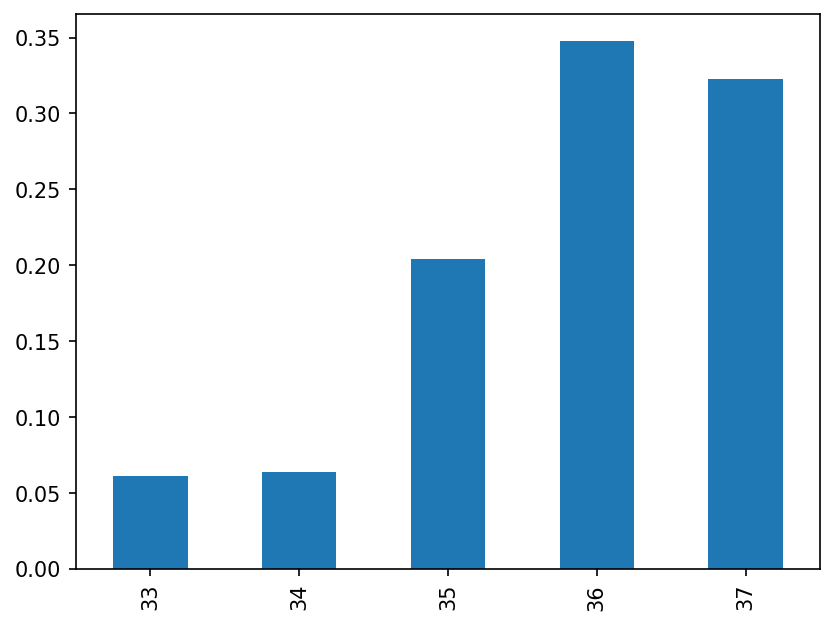

In [60]:
pd.Series(charlson).value_counts(normalize=True).sort_index().plot.bar();

A small, but important, sidenote: There may be some empty categories (for instance there does not seem to be a person who has a score of 26 in our data, but somebody has 30. If we want to adjust for this in the plot, we can reindex the dataframe like this (In our case it does not make a big difference, but it could):

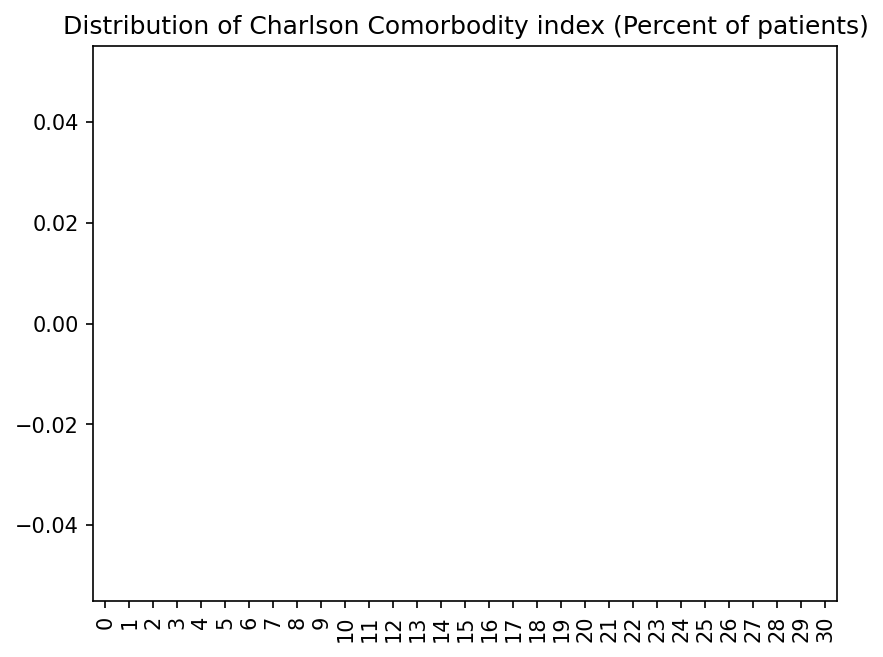

In [62]:
pd.Series(charlson).value_counts(normalize=True).sort_index().reindex(range(31)).plot.bar(title='Distribution of Charlson Comorbodity index (Percent of patients)');

## A never ending story!
The story of the Charlson comorbidity index can be expanded in many directions:
* How to transform and calculate a comparable index when you have different datasets with different coding systems? 
* How to calculate different versions of the index and create a package that would make it easy for other people do do the calculations?
* Could we create functions that make it even easier to express a system of code groups in a single string, insterad of first creating a large number of lists?
* Also: Maybe the approach could be expanded to include calculations of other similar types of indicies that are commonly used in medical research? 

However, these are topics for a new notebook. The aim of this notebook was limited to developing functions that would make it easier to express groups of medical codes. The Charlson comorbidity index demonstrates the usefulness of this notatio; not only to express groups, but also to avoid mistakes since the notation makes patterns more visible, and avoids verbose lists that are too large to double-check quickly.


# More
There is a good package in R, [comorbodity](https://ellessenne.github.io/comorbidity/), that calculates different versions of comorbidity indicies. 